## Imports

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, execute, transpile, Aer, QuantumRegister   
from qiskit.visualization  import plot_histogram
import numpy as np

In [23]:
from quantuminspire.credentials import enable_account
from quantuminspire.qiskit import QI

### Authentication

In [26]:
from getpass import getpass

def get_authentication():
    """Gets the authentication for connecting to the
       Quantum Inspire API.
    """
    print("Enter email:")
    email = input()
    print("Enter password")
    password = getpass()
    return email, password 

if 'authentication' not in vars().keys():
    authentication = get_authentication()
    QI.set_authentication_details(*authentication)
    qi_backend = QI.get_backend('QX single-node simulator')

Enter email:


 avneeshverma03@gmail.com


Enter password


 ····················


## Circuit creation functions

In [86]:
def create_bell_pair(circ):
    circ.h(0)
    circ.cx(0,1)
    circ.barrier()

In [87]:
def encode_message(circ):
    message = ""
    while not (message=="00" or message=="01" or message=="10" or message=="11"):
        print("Enter two-bit message (either 00, 01, 10, or 11):")
        message = input()
    if message == "00":
        pass
    elif message == "01":
        circ.z(0)
    elif message == "10":
        circ.x(0)
    elif message == "11":
        circ.x(0)
        circ.z(0)
    else:
        print("An error occurred")
    circ.barrier()

In [88]:
def bell_measurement(circ):
    circ.cx(0,1)
    circ.h(0)
    circ.measure(0,0)
    circ.measure(1,1)

## Creating the circuit
Run the following code cell, and enter a two-bit message

Enter two-bit message (either 00, 01, 10, or 11):


 01


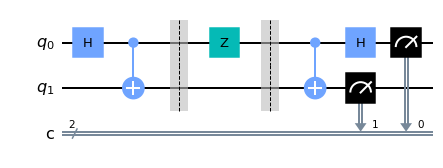

In [89]:
circuit = QuantumCircuit(2,2)
create_bell_pair(circuit)
encode_message(circuit)
bell_measurement(circuit)
circuit.draw("mpl")

## Running the Circuit

Generated histogram:
{'01': 4096}


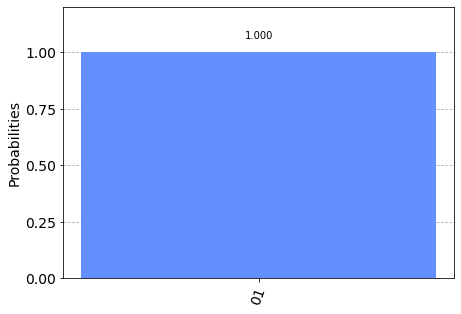

In [90]:
# Run on simulator
iqi_backend = QI.get_backend('QX single-node simulator')
j=execute(circuit, backend=iqi_backend, shots=4096)
result = j.result()
print('Generated histogram:')
print(result.get_counts())
plot_histogram(result.get_counts())

Generated histogram:
{'00': 390, '01': 3404, '10': 74, '11': 228}


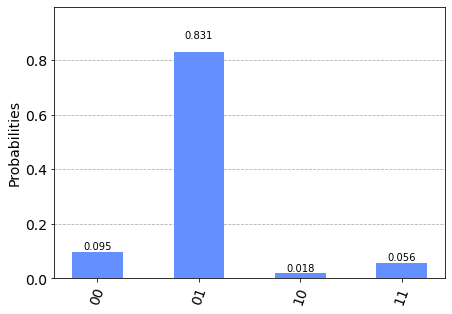

In [91]:
# Run on hardware
iqi_backend = QI.get_backend('Starmon-5')
j=execute(circuit, backend=iqi_backend, shots=4096)
result = j.result()
print('Generated histogram:')
print(result.get_counts())
plot_histogram(result.get_counts())

## Error Mitigation

In [78]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [92]:
qr = QuantumRegister(5)
qubit_list = [1,2]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
state_labels

['00', '01', '10', '11']

In [93]:
iqi_backend = QI.get_backend('Starmon-5')
job = execute(meas_calibs, backend=iqi_backend, shots=4096)
cal_results = job.result()

In [94]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.941 0.108 0.065 0.005]
 [0.027 0.856 0.001 0.044]
 [0.032 0.002 0.908 0.088]
 [0.    0.034 0.026 0.863]]


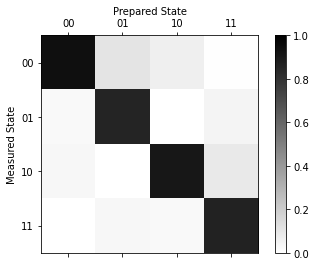

In [95]:
meas_fitter.plot_calibration()

In [96]:
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

# What is the measurement fidelity of Q0?
print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
    label_list = [['00','01'],['10','11']]))

Average Measurement Fidelity: 0.892000
Average Measurement Fidelity of Q0: 0.954250


In [97]:
# Results without mitigation
raw_counts = result.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result)
mitigated_counts = mitigated_results.get_counts(0)

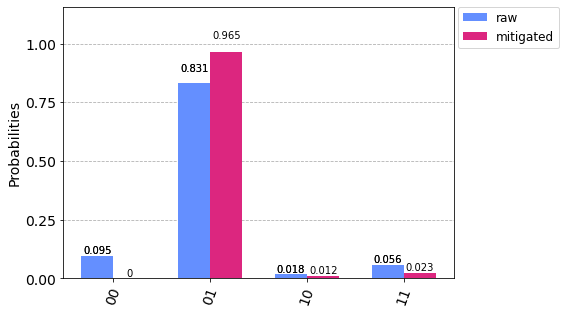

In [98]:
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

Defining a Metric for Error Correction Codes There are numerous approaches to determining how robust an error correcting code is. The easiest place to start is with the ratio of encoded qubits to physical qubits. More effiecient codes requiring fewer physical qubits for each encoded qubit are preferred. In the case of repetition code, $|\bar{0}> =|000>$ and $|\bar{1}> = |111>$, we require 3 physical qubits for each encoded qubit. The second aspect to take into consideration is how many errors are required to map one encoded qubit to another; we call this the distance. Again considering the repetition code if we have one bit flip we can use majority vote and still have the correct encoded qubit. Thus, it takes two bit flips errors to map an encoded qubit to another. However, a single phase error, Pauli $Z$, takes the encoded qubit $|\bar{\text{+}}> = \frac{1}{\sqrt{2}}(|111> + |000>)$ to the encoded qubit $|\bar{\text{-}}> = \frac{1}{\sqrt{2}}(|111> - |000>)$. Thus, the minimum number of errors required to map one encoded qubit to another is 1: $distance=1$. Since quantum computers have different probabilities for different errors, we must take into account both the distance and the probability of the specific error. What we are interested in is the product of the distance and the probability of a specific error occurring, we define this this product to be total distance. We define our metric to be \begin{equation} M = \text{total distance}\frac{\text{encoded qubits}}{\text{physical qubits}} \end{equation}